# Explore Spatial Autocorrelation and Spatial Lag Terms
1. Prepare TAZ shapefile
2. Map neighbors
3. Apply spatial lags

In [1]:
# general import
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# additional import
import geohash
import geopandas as gpd
import pysal as ps  # may be defective on some machines

# local import
from rdforecast import datasets

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
path = './input/'
# retrieve data from source url (if filepath is None)
data = datasets.load_training_data(filepath=path+'training.csv')
data = datasets.check_sanity(data)
data = datasets.process_timestamp(data)
data.head()

Data loaded.
TAZ: 1329
N: 4206321
  geohash6  day timestamp    demand
0   qp03wc   18      20:0  0.020072
1   qp03pn   10     14:30  0.024721
2   qp09sw    9      6:15  0.102821
No missing values found.
First day in sequence: 1
Last day in sequence: 61


,geohash6,day,timestamp,demand,timestep,weekly,quarter,hour,dow
0,qp03wc,18,20:0,0.020072,1712,368,80,20,4
1,qp03pn,10,14:30,0.024721,922,250,58,14,3
2,qp09sw,9,6:15,0.102821,793,121,25,6,2
3,qp0991,32,5:0,0.088755,2996,308,20,5,4
4,qp090q,15,4:0,0.074468,1360,16,16,4,1


# 1. Shapefile

In [3]:
def geohash_to_polygon(hashcode):
    from shapely.geometry import Polygon
    box = geohash.bbox(hashcode)
    vertices = [(box['w'], box['n']),
                (box['e'], box['n']),
                (box['e'], box['s']),
                (box['w'], box['s'])]
    return Polygon(vertices)

In [4]:
# generate shapefile for all TAZs
tazs = list(data['geohash6'].unique())
geometry = [geohash_to_polygon(taz) for taz in tazs]
shp = gpd.GeoDataFrame({'geohash6': tazs}, geometry=geometry)
shp.crs = {'init': 'epsg:4326'}
assert len(shp) == len(data['geohash6'].unique())
shp.to_file(path+'shapefiles/taz.shp')

# assert adjacency
a = shp[shp['geohash6'] == 'qp03wc']['geometry'].values[0]
b = np.array([a.intersects(shp[shp['geohash6'] == gh]['geometry'].values[0])
              for gh in geohash.neighbors('qp03wc')])
assert sum(b == False) == 0

In [5]:
unit_area = shp.to_crs(epsg=3857)['geometry'][0].area / 1000000
print('TAZ area: {} (km^2)'.format(unit_area))

TAZ area: 0.7511311908614264 (km^2)


# 2. Neighbors

In [6]:
def get_neighbors(taz, valid_tazs, units=5):
    """Get units * units blocks centered at taz."""
    i = 0
    assert (units % 2 == 1) & (units > 1), 'units should be an odd number > 1'
    rounds = (units - 1) / 2
    res = {taz}
    new = {taz}
    while i < rounds:
        new = set(np.ravel([geohash.neighbors(t) for t in new]))
        new = new.intersection(valid_tazs)
        res.update(new)
        i += 1
    return res

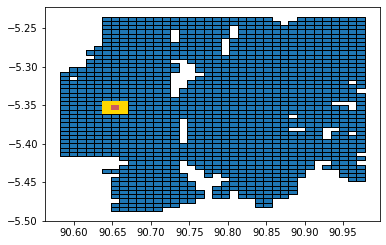

In [7]:
# generate neighbor TAZ mapper
nbr_mapper = {taz: get_neighbors(taz, tazs, 3) for taz in tazs}

# plot an example
ax = shp.plot(linewidth=1, edgecolor='black')
shp[shp['geohash6'].isin(nbr_mapper['qp03wc'])].plot(ax=ax, color='gold')
shp[shp['geohash6'] == 'qp03wc'].plot(ax=ax, color='indianred');

# 3. Spatial Lag

In [8]:
def compare_map(shp, col1, col2):
    fig = plt.figure(figsize=(22,8))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    shp.plot(figsize=(10,6), vmax=0.7, column=col1, ax=ax1)
    shp.plot(figsize=(10,6), vmax=0.7, column=col2, ax=ax2)

In [9]:
# pivot data
pivoted = data.pivot(index='geohash6', columns='timestep', values='demand').reset_index()
output = shp.merge(pivoted, how='left', on='geohash6')
output.columns = output.columns.astype(str)
assert len(shp) == len(pivoted) == len(output)
output.iloc[:,:300].to_file(path+'shapefiles/taz_timestep.shp')  # just save a sample
# output.to_csv(path+'taz_timestep.csv', index=None)

In [10]:
# read in shapefile with queen contiguity
shp_qw = ps.queen_from_shapefile(path+'shapefiles/taz_timestep.shp')
shp_qw.transform = 'r'

In [11]:
shp_ = gpd.read_file(path+'shapefiles/taz_timestep.shp')

In [12]:
# inspect spatial lag on demands
ts = '200'
values = shp_[ts]
lag = ps.lag_spatial(shp_qw, values)
# shp_[str(ts)+'_lag'] = values + 0.3 * lag
shp_[str(ts)+'_lag'] = lag

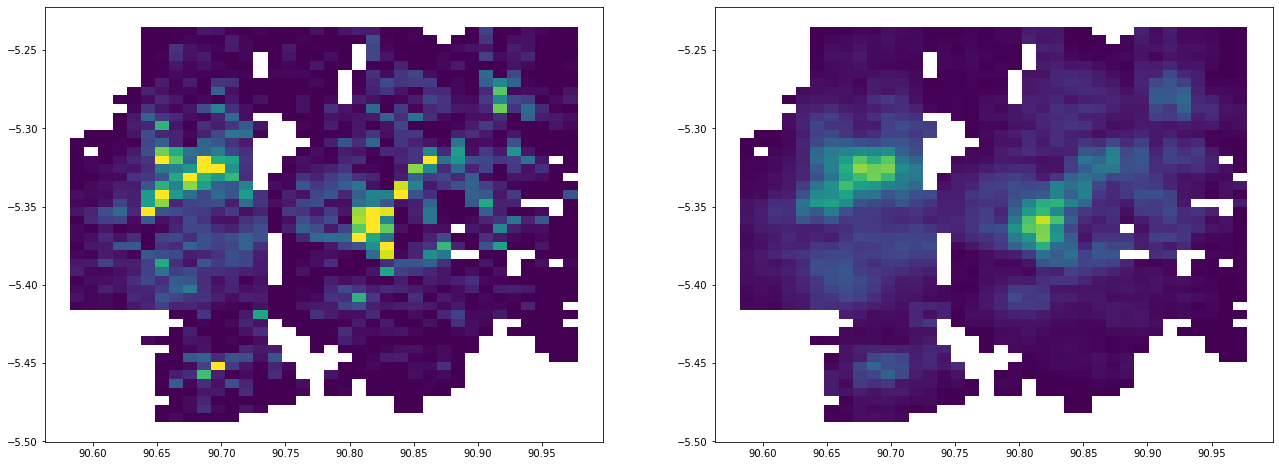

In [13]:
compare_map(shp_, ts, str(ts)+'_lag')

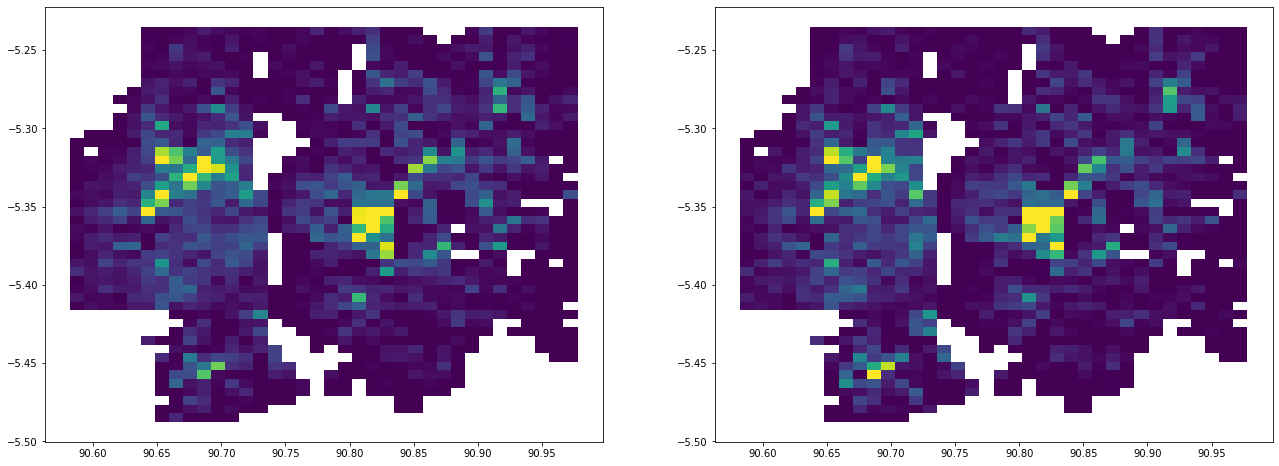

In [14]:
compare_map(shp_, str(int(ts)+1), str(int(ts)+4))

In [15]:
# check correlations
df = pd.read_csv(path+'taz_timestep.csv')
dfT = df.T
dfT.columns = df['geohash6']
dfT = dfT.iloc[2:,:]
dfT = dfT.astype(float)
corrtab = dfT.corr()
corrtab.round(3).to_csv('./output/taz_corr.csv')